# Building Interpretable Models on Imbalanced Data
## Predicting customer churn from a telecom provider 

I've always believed that to truely learn data science you need to practice data science and I wanted to do this project to practice working with imbalanced classes in classification problems. This was also a perfect oppurtinity to start working with [mlflow](https://mlflow.org/) to help track my machine learning experiments: it allows me to track the different models i've used, the parameters i've training with, and the metrics i've recorded.

This project was aimed at predicting customer churn using the teleccomunications data found on [Kaggle](https://www.kaggle.com/c/customer-churn-prediction-2020/overview). That is, we want to be able to predict if a given customer is going the leave the telecom provider based on the infromation we have on that customer. Now why is this useful? Well, if we can predict which customers we think are going to leave **before** they actually leave then we can try to do something about it! For example, we could target them with specific offers, and maybe we could even use the model to provide us insight into what to offer them because we will know, or at least have an idea, as to why they are leaving. 

## Performance vs Interpretability 
It's very important to know and understand the problem/task at hand before we start to even think about writing any code. Would it be useful in this case to build a really powerful model like XGBOOST? No, of course not. Our goal isn't to squeeze every drop of performance out of our model. Our goal is to **understand** why people are leaving so we can actually do something about it and try to get them to stay. In an ideal world we would build a very interpretable model, but in reality we are going to have to find a happy medium between performance and interpretability. Logistic regression would be a good start.

## Model Evaluation
We now need to decide how we are going to evaluate our models and what we are going to be happy with. Personally, I think it's important to decide an end goal beforehand as otherwise it's going to be hard to decide when to stop. 

Due to the nature of our data it is likely that our classes are going to be highly imbalanced, with the case we are interested in (customers leaving) being the minority class. This makes selecting the right metric super important.

<img src="data/blog_content/class_imbalance_meme.jpg" width="300" align="center"/>
    
The metrics we are going to be interested in are **precision**, **recall**, and other metrics associated with these. Precision is the ratio of correct positive predictions to the overall number of positive predictions. Recall is the ratio of correct positive predictions to the overall number of positive predictions in the dataset. 
In our case we are looking at trying to retain customers by predicting which customers are going to leave: so we aren't too fussed if we miss-classify some customers as 'churn' when they are not (false positives). If anything, these miss-classifications might be customers that would soon become 'churn' if nothing changes. That is, they may lie on or near the decision boundary. So, we are looking to **maximize recall** as it will minimize the number of false negatives. 

We are also going to look at the **F-measure** as it provides a way to express both concerns of precision and recall with a single score - we don't just want to forfeit precision to get 100% recall!

### Model Specifications
Once we have built our final model, we can then use a precision-recall curve to optimize our performance of on the positive (minority class). In this case we are going to assume that stakeholders in our imaginary telecoms business want to **achieve a recall of 0.70** (i.e. we identify 70% of the positive samples correctly) while maximizing precision. 


## Data
* train.csv - the training set. Contains 4250 rows with 20 columns. 3652 samples (85.93%) belong to class churn=no and 598 samples (14.07%) belong to class churn=yes.
* test.csv - the test set. Contains 850 rows with 18 columns.

The 20 columns contain the following information:
* **state**, string. 2-letter code of the US state of customer residence
* **account_length**, numerical. Number of months the customer has been with the current telcom provider
* **area_code**, string="area_code_AAA" where AAA = 3 digit area code.
* **international_plan**, (yes/no). The customer has international plan.
* **voice_mail_plan**, (yes/no). The customer has voice mail plan.
* **number_vmail_messages**, numerical. Number of voice-mail messages.
* **total_a_b** with **a = (day, eve, night, intl)** and **b = (minutes, calls, charge)**, numerical. Total (minutes, calls, charge) of (day, eve, night, intl) calls.
* **number_customer_service_calls**, numerical. Number of calls to customer service
* **churn**, (yes/no). Customer churn - target variable.

In [52]:
import pandas as pd
from src.data.load_data import read_params
# load in training data 
config = read_params("params.yaml")
external_data_path = config["external_data_config"]["external_data_csv"]
df = pd.read_csv(external_data_path, sep=",", encoding="utf-8")
# check we have our 20 cols
assert len(df.columns) == 20

EDA (along with the all the modeling etc.) was done in different python scripts and I have chosen to not include it here as it is irrelevant to the topic I am writing about. It is nonetheless very important and you can find this whole project on my [Github page](https://github.com/jackmleitch/CustomerChurn). 


Due to the high cardinality of the area_code and state columns we are going to drop these for our experiments. If we wanted to use it we could always bin the states by region as this might contain key information regarding churn rate (for example, bad phone service).

In [53]:
df = df.drop(columns=["area_code", "state"], axis=1)
df.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,121,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


We can look at a correlation matrix to see any initial promising features.

<AxesSubplot:>

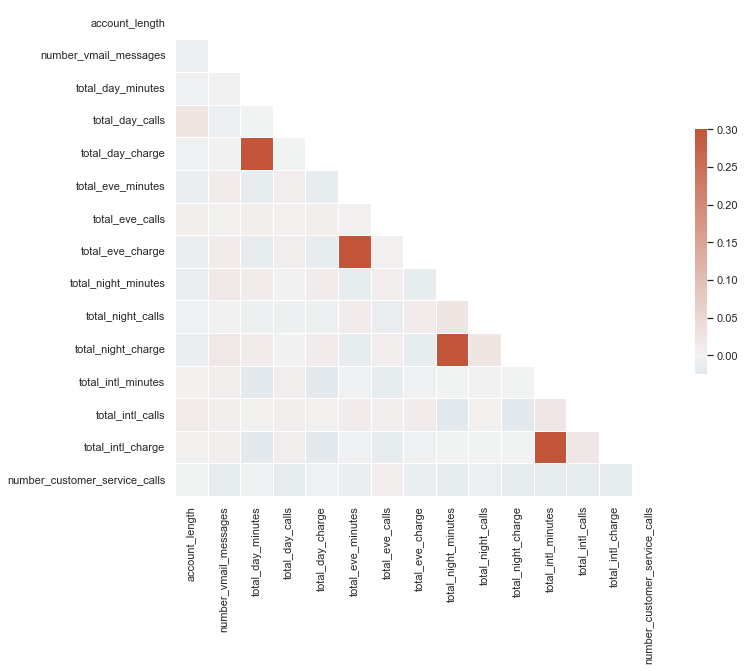

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Ok, this doesn't look great but we can see that churn is somewhat correlated with total_day_minutes, total_day_charge, and number_customer_service_calls. Let's build a simple **baseline model** with total_day_minutes and number_customer_service_calls (we omit total_day_charge because it's strongly correlated with total_day_minutes).

## Modeling   
The first thing I always do is split the data into train and validation sets. In this case we use stratified K-fold cross-validation as our dataset is highly imbalanced and we want to ensure the class distribution is consistent across folds. 

In [55]:
from sklearn.model_selection import StratifiedKFold

def stratKFold(df, n_splits=5):
    """
    Perform stratified K fold cross validation on training set
    :param df: pd dataframe to split
    :param n_splits: number of folds 
    :return: df with kfold column
    """
    # create new column 'kfold' with val -1
    df["kfold"] = -1
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    # target values
    y = df['churn'].values
    # initialise kfold class
    kf = StratifiedKFold(n_splits=n_splits)
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, "kfold"] = f
    return df
        
df = stratKFold(df)

We can now go ahead and map our churn column to numeric values.

In [56]:
# target mapping
target_mapping = {"no": 0, "yes": 1}
df.loc[:, 'churn'] = df['churn'].map(target_mapping)

### Baseline Model
We start by building a simple baseline model so that we have something to compare our later models to. In a regression scenario we could simply use the average of the target variable at every prediction, in our classification case however we are going to use a logistic regression model trained on our two most correlated features. 

Before we start lets initialize Mlflow and write a general scoring function to evaluate our model.

In [57]:
import mlflow 
from sklearn.metrics import f1_score, recall_score, precision_score

# initialize mlflow
mlflow.set_experiment("mlflow/customer_churn_model")

# scoring function 
def score(y, preds):
    """
    Returns corresponding metric scores 
    :param y: true y values
    :param preds: predicted y values
    :return: f1_score, recall, and precision scores 
    """
    f1 = f1_score(y, preds)
    recall = recall_score(y, preds)
    precision = precision_score(y, preds)
    return [f1, recall, precision]

Now let's build our baseline model and see how it does on each validation set!

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# baseline model
f1_scores, recall_scores, precision_scores = [], [], []
for fold in range(5):
    # define train and validation set
    features = ["total_day_minutes", "number_customer_service_calls"]
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    # target and features
    y_train = df_train['churn'].values
    y_valid = df_valid['churn'].values
    # init and fit scaler 
    scaler = StandardScaler()
    x_train = scaler.fit_transform(df_train[features])
    x_valid = scaler.transform(df_valid[features])
    # create and train model
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    preds = clf.predict(x_valid)
    # score model
    scores = score(y_valid, preds)
    f1_scores.append(scores[0])
    recall_scores.append(scores[1])
    precision_scores.append(scores[2])
# average scores over each fold
f1_avg = np.average(f1_scores)
recall_avg = np.average(recall_scores)
precision_avg = np.average(precision_scores)
print(f"Average F1 = {f1_avg}, Recall = {recall_avg}, Precision = {precision_avg}")

# log metrics on mlflow 
with mlflow.start_run(run_name="lr_baseline") as mlops_run:
        mlflow.log_metric("F1", f1_avg)
        mlflow.log_metric("Recall", recall_avg)
        mlflow.log_metric("Preision", precision_avg)

Average F1 = 0.08725760427444854, Recall = 0.04847338935574229, Precision = 0.440932400932401


So yea, the results aren't great (actually they are terrible (I was trying to be positive!)) but that only means we are going to get better. This was only a baseline! We can do a few things to improve our model: 
* We can balance out our classes by over and under-sampling as the imbalance is causing bias towards the majority class in our model.
* We can train on more features.

### SMOTE: To Over-Sample the Minority Class
One problem we have with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem would be to over-sample the examples in the minority class. This could be achieved by simply duplicating examples from the minority class in the training dataset, although this does not provide any additional information to the model. An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. A common technique for this, introduced in [this paper](https://arxiv.org/abs/1106.1813), is SMOTE. It's worth noting that over sampling isn't our only option, we could for example  under-sample (or combine a mix of the two) by using a technique such as [TOMEK-links](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#Tomek_links) (SMOTE-TOMEK helps do both under and over-sampling in one go). In our case however, the best performance boost came from SMOTE alone. 

Before we do this however, lets write a general feature processing pipeline to get our data ready for modeling. Our function returns a Sklearn pipeline object that we can use to fit and transform our data. It first splits the data into numeric and categorical features. The categorical features as encoded using one-hot encoding. The numeric features first have their missing values imputed, they then are scaled to be between 0 and 1. It's worth noting that scaling isn't actually necessary for logistic regression unless you are using regularization, but in our case it did boost the performance.

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from mlxtend.feature_selection import ColumnSelector

def feature_pipeline(config_path="params.yaml"):
    """
    :param config_path: path to params.yaml file
    :return: preprocessing feature pipeline 
    """
    # load in config information
    config = read_params(config_path)
    num_features = config["raw_data_config"]["model_features"]["numeric"]
    cat_features = config["raw_data_config"]["model_features"]["categorical"]
    # transformers
    transforms = []
    # categorical pipeline
    transforms.append(
        (
            "catergorical",
            Pipeline(
                [
                    ("select", ColumnSelector(cols=cat_features)),
                    ("encode", OneHotEncoder()),
                ]
            ),
        )
    )
    # numeric pipeline
    transforms.append(
        (
            "numeric",
            Pipeline(
                [
                    ("select", ColumnSelector(cols=num_features)),
                    ("impute", SimpleImputer(missing_values=np.nan, strategy="mean")),
                    ("scale", MinMaxScaler()),
                ]
            ),
        )
    )
    # combine features
    features = FeatureUnion(transforms)
    return features

A general training function is written below, notice we can choose whether we want to use SMOTE or not.

In [60]:
from imblearn.over_sampling import SMOTE
def train(fold, df, model=LogisticRegression(solver='newton-cg'), smote=False):
    """
    :param fold: fold to train model on
    :param df: pandas dataframe containing our data
    :param model: model to train data on
    :param smote: boolean, perform smote over-sampling 
    :return: f1, recall, precision validation score for fold, as well as y_valid and preds
    """
    # feature pipeline
    features = feature_pipeline()

    # define train and validation set
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    # target and features
    y_train = df_train['churn'].values
    y_valid = df_valid['churn'].values

    # create training and validation features
    x_train = features.fit_transform(df_train)
    x_valid = features.transform(df_valid)

    # smote
    if smote:
        smt = SMOTE(random_state=42)
        x_train, y_train = smt.fit_resample(x_train, y_train)

    # create and train model
    clf = model
    clf.fit(x_train, y_train)
    preds = clf.predict(x_valid)
    # score model
    scores = score(y_valid, preds)
    return scores, [y_valid, preds]

Before we use SMOTE, let's train a logistic regression model on all of the features to try and get a new baseline.  

In [61]:
f1_scores, recall_scores, precision_scores = [], [], []
for fold in range(5):
    scores, _ = train(fold,df, smote=False)
    f1, recall, precision = scores
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
# average scores over each fold
f1_avg = np.average(f1_scores)
recall_avg = np.average(recall_scores)
precision_avg = np.average(precision_scores)
print(f"Average F1 = {f1_avg}, Recall = {recall_avg}, Precision = {precision_avg}")
# log metrics on mlflow 
with mlflow.start_run(run_name="lr_all_features") as mlops_run:
        mlflow.log_metric("F1", f1_avg)
        mlflow.log_metric("Recall", recall_avg)
        mlflow.log_metric("Preision", precision_avg)

Average F1 = 0.27017200240542266, Recall = 0.1923109243697479, Precision = 0.4552432895715858


The results are definitely better than before but still not great. We've waited long enough, let's try using SMOTE! We are going to use SMOTE to over-sample our churn datapoints so that we end up with equal class distributions. 

In [62]:
def train_and_eval(df, model=LogisticRegression(solver='newton-cg'), smote=True, model_name="", params = {}):
    '''
    train model and evaluate it on each fold
    :param df: pandas dataframe containing our data
    :param model: model to train data on
    :param model_name: string, for tracking on mlflow
    :param model_name: dict, for tracking on mlflow
    :return: average score for each metric
    '''
    f1_scores, recall_scores, precision_scores = [], [], []
    for fold in range(5):
        scores, _ = train(fold, df, model=model, smote=smote)
        f1, recall, precision = scores
        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
    # average scores over each fold
    f1_avg = np.average(f1_scores)
    recall_avg = np.average(recall_scores)
    precision_avg = np.average(precision_scores)
    print(f"Average F1 = {f1_avg}, Recall = {recall_avg}, Precision = {precision_avg}")
    # log metrics on mlflow 
    with mlflow.start_run(run_name=model_name) as mlops_run:
            mlflow.log_metric("F1", f1_avg)
            mlflow.log_metric("Recall", recall_avg)
            mlflow.log_metric("Preision", precision_avg)
            if params:
                mlflow.log_params(params)

In [63]:
train_and_eval(df, model_name="lr_all_features_smote")

Average F1 = 0.5956485540301312, Recall = 0.8377591036414567, Precision = 0.4624717240827412


Wow! We have boosted the F1 score from 0.28 to 0.61, and the recall has gone from 0.20 to 0.84! An important note is that the precision has practically stayed the same. Why is that? Well, what is precision measuring? Mathematically, precision the number of true positives divided by the number of true positives plus the number of false positives. It tells us that our model is correct 47% of the time when trying to predict positive samples. So by over-sampling we have decreased the number of false negatives but we have also increased the number of false positives. This is OK as we decided we will favor false positives over false negatives. An intuitive way to see this change is by looking at a **confusion matrix**. 

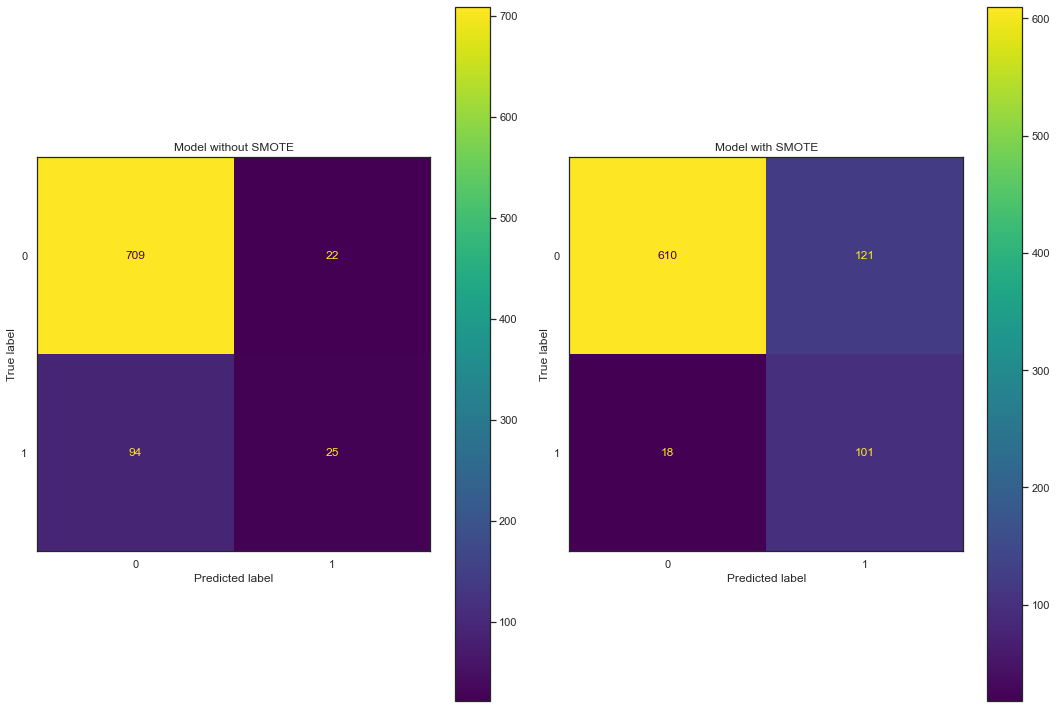

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# get preds for non-smote and smote models
_, evals = train(0, df, smote=False)
_, evals_smote = train(0, df, smote=True)
# set axis and plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.set_title("Model without SMOTE")
ConfusionMatrixDisplay.from_predictions(*evals, ax=ax1)
ax2.set_title("Model with SMOTE")
ConfusionMatrixDisplay.from_predictions(*evals_smote, ax=ax2)
plt.tight_layout()  
plt.show()

We can see that the TP number goes from 25 to 101 and the FN number goes from 94 to 18, great! However, as a consequence of this we see the FP number goes from 22 to 121. But, as mentioned earlier, we are ok with that as we care more about finding out which customers are going to leave. 
A little side note: the FP and FN rates can be tuned using the probability threshold and the easiest way to compare the two models is to compare F1 scores.

### But can we do better?
It would be easy here to go all guns blazing and train an XGBOOST model, but remember that is **not** our goal. Our goal is to build an **interpretable** model that we can use to try and keep customers from leaving. 
As well as logistic regression, decision tree classifiers are very interpretable. Let's see how it gets on.

In [65]:
from sklearn.tree import DecisionTreeClassifier
train_and_eval(df, model=DecisionTreeClassifier(), model_name="dt_all_features_smote")

Average F1 = 0.6543680178003948, Recall = 0.7392156862745097, Precision = 0.589622338754265


It does well! The recall is slightly worse but the precision is a lot higher. Let's go ahead and tune hyperparameters on both models to see if we can optimize things more. We will use random search as the models are pretty small, but for larger models I recommend checking out Bayesian optimization. [Optuna](https://optuna.org/) implements it fantastically with its TPE sampler. 

In [66]:
from scipy.stats import loguniform
# define search spaces
lr_space = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': loguniform(1e-5, 100)
}
# limit max_depth as prone to over-fitting
dt_space = {'max_depth':[2,3,4,5], 
            'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_samples_split':[1,2,3,4,5,6,8,10],
            'criterion': ["gini", "entropy"]
           }

In [210]:
# random search to find best hyperparams
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
def hyperparameter_optim(df, model, params):
    '''
    Optimize hyperparameters for given model using random search 
    and stratified k fold cross validation
    :param df: pandas dataframe
    :param model: model to optimize
    :param params: param dictionary to search
    '''
    # feature pipeline
    features = feature_pipeline()
    # target and features
    x_train = features.fit_transform(df)
    y_train = df['churn'].values
    # smote
    smt = SMOTE(random_state=42)
    x_train, y_train = smt.fit_resample(x_train, y_train)
    # define model
    model = model
    # define cross val.
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # define search
    search = RandomizedSearchCV(model, params, n_iter=500, scoring='f1', n_jobs=-1, cv=cv, random_state=1)
    # execute search
    result = search.fit(x_train, y_train)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    
# hyperparameter_optim(df, DecisionTreeClassifier(), dt_space)
# hyperparameter_optim(df, LogisticRegression(), lr_space)

This gives us the following results:
* **Logistic Regression** Best Hyperparameters: {'C': 68, 'penalty': 'l1', 'solver': 'liblinear'}
* **Decision Tree** Best Hyperparameters: {'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini'}

Let's train some model with these parameters and see what we get!

In [68]:
lr_params = {'C': 68, 'penalty': 'l1', 'solver': 'liblinear'}
train_and_eval(df, model=LogisticRegression(**lr_params), model_name="lr_smote_tuned", params=lr_params)

Average F1 = 0.5973957674491757, Recall = 0.8377591036414567, Precision = 0.46454578772672034


In [78]:
dt_params = {'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini'}
train_and_eval(df, model=DecisionTreeClassifier(**dt_params), model_name="dt_smote_tuned", params=dt_params)

Average F1 = 0.7188331504493051, Recall = 0.7391316526610645, Precision = 0.7043058129765436


Great, so we now have two potential models. We are going to move forward with the decision tree model as the logistic regression model isn't quite up to scratch. We do however need to be careful, decision trees are very prone to overfitting and this is why random forest models are usually preferred. So make sure to always train in a cross-validated manor. The random forest can generalize over the data in a better way as the randomized feature selection acts as a form of regularization. As discussed earlier though, in our case we care more about interpretability than performance. 

Ok, so lets train a final model on the whole dataset using our hyperparams found earlier. We can then fine-tune the probability threshold so we can meet our target of a 0.70 recall while maximizing precision.

In [211]:
def train_full(df, model, params):
    """
    :param df: pandas dataframe containing our data
    :param model: model to train data on
    :param params: model hyperparameters
    :return: f1, recall, precision validation score for fold, as well as y_valid and preds
    """
    # feature pipeline
    features = feature_pipeline()

    # target and features
    x_train = features.fit_transform(df)
    y_train = df['churn'].values

    smt = SMOTE(random_state=42)
    x_train, y_train = smt.fit_resample(x_train, y_train)

    # create and train model
    clf = model(**params)
    clf.fit(x_train, y_train)
    return clf, features

In [108]:
clf, features = train_full(df=df, model=DecisionTreeClassifier, params=dt_params)

We can now tune the probability threshold to try and optimize our precision recall trade-off, we will do this in a cross-validated manor. Let's plot a precision recall curve and find the optimal threshold to achieve 70% recall.

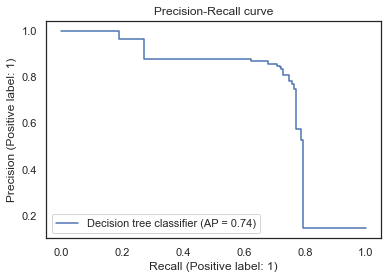

In [212]:
from sklearn.metrics import PrecisionRecallDisplay
# training data
x_train = features.transform(df)
y_train = df['churn'].values
# precision recall curve
display = PrecisionRecallDisplay.from_estimator(
    clf, x_train, y_train, name="Decision tree classifier"
)
_ = display.ax_.set_title("Precision-Recall curve")

In [213]:
from sklearn.metrics import precision_recall_curve
def optimize_threshold(clf, df, recall = 0.70):
    '''
    Uses cross-validation to optimize prob. threshold for required task
    :param clf: model to optimize
    :param df: training data with kfold col
    :param recall: desired recall 
    :return: optimal prob. threshold
    '''
    threshs = []
    # loop over each fold
    for fold in range(5):
        # define train and validation set
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)
        # target and features
        y_train = df_train['churn'].values
        y_valid = df_valid['churn'].values
        # fit model on training data 
        clf, features = train_full(df=df_train, model=DecisionTreeClassifier, params=dt_params)
        # get scores for valid data
        x_valid = features.transform(df_valid)
        y_scores = clf.predict_proba(x_valid)[:, 1]
        # locate where recall is closest to 0.70
        precisions, recalls, thresholds = precision_recall_curve(y_valid, y_scores)
        distance_to_optim = abs(recalls - recall)
        optimal_idx = np.argmin(distance_to_optim)
        threshs.append(thresholds[optimal_idx])
    # average optimal thresh across all folds
    return np.average(threshs)

thresh = optimize_threshold(clf, df)
print(thresh)

0.7166696621135873


We can now write a general predict function that will predict on any new data and only classify as a positive sample when the probability is greater than 0.71. We can then predict on unseen test data to see how we did!

In [217]:
def predict(X, clf, feature_pipeline, thresh=0.71):
    '''
    Predict on new data 
    :param X: data containing features
    :param clf: trained model
    :param feature_pipeline: trained feature processing pipeline
    :param thresh: prediction threshold
    :return: predictions
    '''
    X = feature_pipeline.transform(X)
    preds = (clf.predict_proba(X)[:,1] >= thresh).astype(int)
    return preds

# train full model 
clf, features = train_full(df=df, model=DecisionTreeClassifier, params=dt_params)

# load in test data and score
df_test = pd.read_csv("data/external/test.csv")
# target mapping
target_mapping = {"no": 0, "yes": 1}
df_test.loc[:, 'churn'] = df_test['churn'].map(target_mapping)
y_test = df_test['churn'].values
# predict on unseen data
preds = predict(df_test, clf, features)
# score
f1, recall, precision = score(y_test, preds)
print(f"Average F1 = {f1}, Recall = {recall}, Precision = {precision}")

Average F1 = 0.7190082644628099, Recall = 0.696, Precision = 0.7435897435897436


Perfect, we have achieved the desired recall! It's also nice to see the F1 and precision scores so similar to the cross-validation scores as it shows we haven't overfitted our model! Let's upload this model to mlflow and then finish by looking at interpreting the model.

In [207]:
# log metrics on mlflow 
with mlflow.start_run(run_name="Final DT Model") as mlops_run:
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("Preision", precision)
        mlflow.log_params(dt_params)
        mlflow.log_params({"prob_thresh": 0.71})
        # log model and pipeline
        mlflow.sklearn.log_model(clf, "final_model")
        mlflow.sklearn.log_model(features, "features_pipeline")
        

In [209]:
# import pickle

# with open('models/final_DT_model.pickle', 'wb') as f:
#     pickle.dump(clf, f)

# with open('models/feature_pipeline.pickle', 'wb') as f:
#     pickle.dump(features, f)

#### MLFLOW Experiment Session
<img src="data/blog_content/mlflow.png"/>

## Model Interpreting 